
Melhores parâmetros encontrados:
{'C': 1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}

MAPE: 0.06%

Comparação Final:
        Data  Valor Real  Valor Previsto
0 2024-07-01    161149.0   185562.881423
1 2024-08-01    169700.0   176700.227571
2 2024-09-01    180721.0   176675.957422
3 2024-10-01    173691.0   178161.055592
4 2024-11-01    179036.0   188305.221659
5 2024-12-01    182626.0   200368.398749


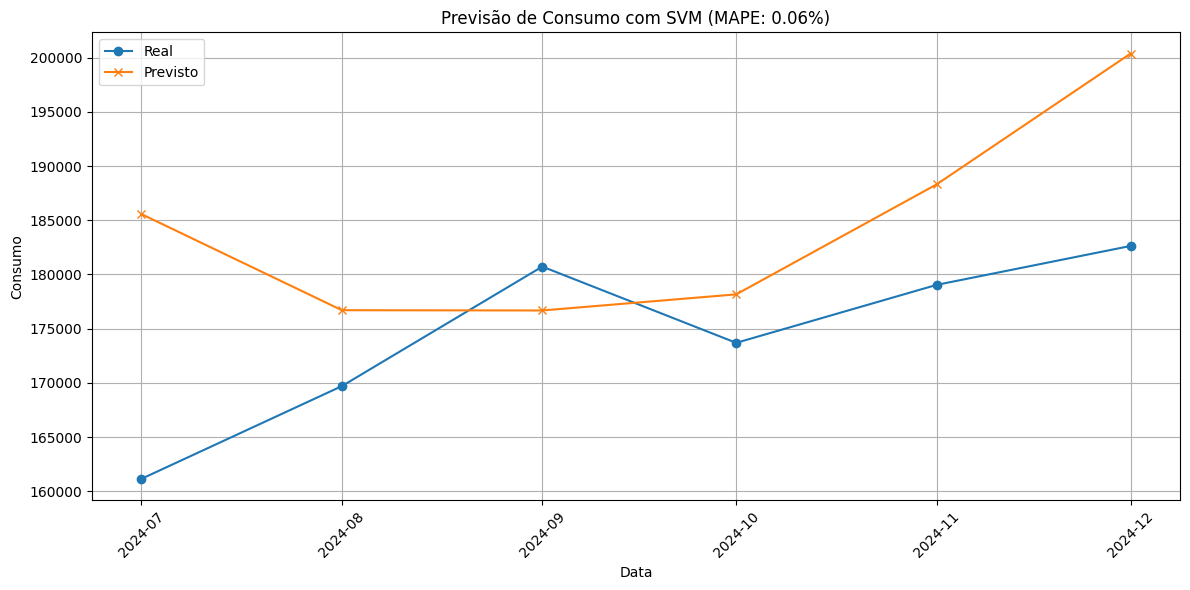

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import os

# Função para criar datasets
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Função principal
def prever_e_plotar(caminho_arquivo):
    # Carregar e preparar dados
    df = pd.read_csv(caminho_arquivo, sep=';')
    df['AM_REFERENCIA'] = pd.to_datetime(df['AM_REFERENCIA'], format='%Y%m')
    df_aggregated = df.groupby('AM_REFERENCIA')['HCLQTCON'].sum().reset_index()
    df_aggregated = df_aggregated.sort_values(by='AM_REFERENCIA')
    
    # Normalização
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_aggregated['HCLQTCON_norm'] = scaler.fit_transform(df_aggregated[['HCLQTCON']])
    
    # Divisão treino-teste usando índices de data
    train_mask = df_aggregated['AM_REFERENCIA'] <= pd.to_datetime('2023-12-31')
    test_mask = (df_aggregated['AM_REFERENCIA'] >= pd.to_datetime('2024-01-01')) & \
                (df_aggregated['AM_REFERENCIA'] <= pd.to_datetime('2024-12-31'))
    
    train_data = df_aggregated[train_mask]['HCLQTCON_norm'].values
    test_data = df_aggregated[test_mask]['HCLQTCON_norm'].values

    # Criar datasets
    look_back = 6
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)
    
    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("Reduza o look_back. Dados insuficientes.")

    # Busca de hiperparâmetros com GridSearchCV
    param_grid = {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1],
        'epsilon': [0.01, 0.1]
    }
    
    svr = SVR()
    grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    # Melhores parâmetros
    best_params = grid_search.best_params_
    print("\nMelhores parâmetros encontrados:")
    print(best_params)
    
    # Treinar modelo final com melhores parâmetros
    best_svr = SVR(**best_params)
    best_svr.fit(X_train, Y_train)
    
    # Previsões
    predictions = best_svr.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()
    
    # Obter as datas correspondentes
    test_dates = df_aggregated[test_mask]['AM_REFERENCIA'].iloc[look_back:].values
    
    # Métricas
    mape_value = mape(Y_test_inv, predictions)
    print(f"\nMAPE: {mape_value:.2f}%")

    # DataFrame de comparação
    comparison_df = pd.DataFrame({
        'Data': test_dates,
        'Valor Real': Y_test_inv,
        'Valor Previsto': predictions
    })

    print("\nComparação Final:")
    print(comparison_df)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Data'], comparison_df['Valor Real'], label='Real', marker='o')
    plt.plot(comparison_df['Data'], comparison_df['Valor Previsto'], label='Previsto', marker='x')
    plt.title(f"Previsão de Consumo com SVM (MAPE: {mape_value:.2f}%)")
    plt.xlabel("Data")
    plt.ylabel("Consumo")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Execução
if __name__ == "__main__":
    path = 'E:\\Projetos\\ABMS-WP'
    caminho_arquivo = os.path.join(path, 'includes\\Tabela_consumo_Itapua_120m.csv')
    prever_e_plotar(caminho_arquivo)